In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_prnu(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.float32)
    
    denoised = cv2.medianBlur(gray, 3)
    noise = gray - denoised

    return noise

def detect_manipulation(image):
    noise_full = extract_prnu(image)

    block_size = 2

    h, w = noise_full.shape

    std_map = np.zeros((h // block_size, w // block_size))

    for i in range(0, h - block_size + 1, block_size):
        for j in range(0, w - block_size + 1, block_size):
            block_noise = noise_full[i:i+block_size, j:j+block_size]
            std = np.std(block_noise)
            std_map[i // block_size, j // block_size] = std

    std_map_resized = cv2.resize(std_map, (w, h), interpolation=cv2.INTER_NEAREST)

    std_map_norm = (std_map_resized - np.min(std_map_resized)) / (np.max(std_map_resized) - np.min(std_map_resized))

    threshold = np.mean(std_map_norm) - 0.05
    mask = std_map_norm < threshold

    return mask, std_map_norm

def overlay_mask_on_image(image, mask):
    overlay_image = image.copy()

    mask_uint8 = (mask * 255).astype(np.uint8)

    mask_color = np.zeros_like(image)
    mask_color[:, :, 0] = mask_uint8

    alpha = 0.5
    cv2.addWeighted(mask_color, alpha, overlay_image, 1 - alpha, 0, overlay_image)

    return overlay_image

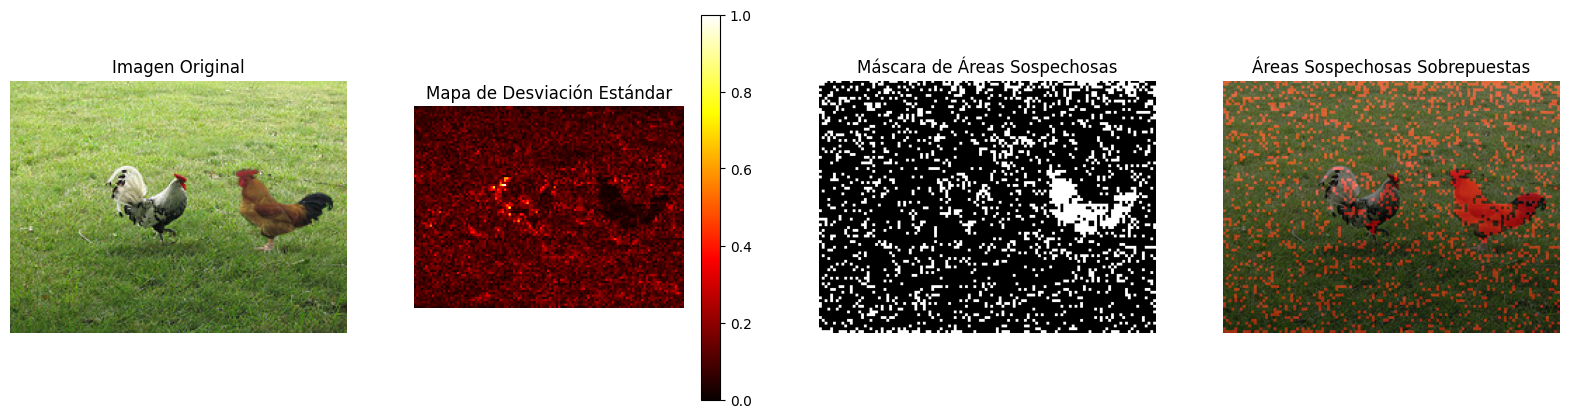

In [9]:
image_path = "D:/dataset--ml/CASIA2-Train/Tp/Tp_D_CRN_M_N_ani10104_ani00100_10093.tif"
image = cv2.imread(image_path)

if image is None:
    print("No se pudo cargar la imagen. Verifica la ruta.")

else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask, std_map_norm = detect_manipulation(image_rgb)

    overlay_image = overlay_mask_on_image(image_rgb, mask)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(image_rgb)
    plt.title('Imagen Original')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(std_map_norm, cmap='hot')
    plt.title('Mapa de Desviación Estándar')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(mask, cmap='gray')
    plt.title('Máscara de Áreas Sospechosas')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay_image)
    plt.title('Áreas Sospechosas Sobrepuestas')
    plt.axis('off')

    plt.show()